In [1]:
# Import

import numpy
import torch

import sys
sys.path.append('..')

from harmonica.window import Window

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())
print(torch.get_num_threads())

True
6


In [2]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

# Example-01: Window initialization

In [3]:
# Window is used to fix signal length in computations
# Each signal in TbT should have fixed length defined by selected window length
# Window is also used to set default data type and device for all further computations

# Initialize window instance (with default parameters)

w = Window(length=1024, name=None, order=None, dtype=dtype, device=device)

# String representaion

print(w)

# Window length

print(w.length)

# Window name
# Should be one of the defined static methods ('cosine_window' or 'kaiser_window') or None for empty initialization

print(w.name)

# Window order
# Positive float, not used if name is None

print(w.order)

# Window data (all ones if window name is None)

print(w.window.detach().cpu().numpy())

# Window data type

print(w.dtype)

# Window device

print(w.device)

# Window total (sum of window data)

print(w.total)

# Set custom window (copy tensor with matching length to data)

w.window.copy_(torch.zeros_like(w.window))
print(w.window.cpu().numpy())

# Set custom window (use set_data method to invoke defined static method for given window name)

w.set_data(name='cosine_window', order=0.0)
print(w.window.cpu().numpy())

# Set custom window (use set_data method with given input tensor of matching length)

w.set_data(data=torch.zeros_like(w.window))
print(w.window.cpu().numpy())

# Set custom window (invoke set_data)

w(name='cosine_window', order=0.0)
print(w.window.cpu().numpy())

# Set custom window (invoke set_data)

w(data=torch.zeros_like(w.window))
print(w.window.cpu().numpy())

# Print window attibutes

for key, value in w.__dict__.items():
    print(f'{key}: {value}')

Window(1024, None, None)
1024
None
None
[1. 1. 1. ... 1. 1. 1.]
torch.float64
cpu
tensor(1.024000000000e+03, dtype=torch.float64)
[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]
[0. 0. 0. ... 0. 0. 0.]
[1. 1. 1. ... 1. 1. 1.]
[0. 0. 0. ... 0. 0. 0.]
length: 1024
window: tensor([0., 0., 0.,  ..., 0., 0., 0.], dtype=torch.float64)
dtype: torch.float64
device: cpu
name: None
order: None


# Example-02: Free CUDA memory

In [4]:
# Delete data attribute or whole instance to free CUDA memory
# Call torch.cuda.empty_cache()

# Set window instance

w = Window(1024, None, None, dtype=dtype, device=torch.device('cuda'))
print(w)

# Print allocated memory info

print(torch.cuda.memory_allocated())

# Delete window instance

del w

# Print allocated memory info   

print(torch.cuda.memory_allocated())

Window(1024, None, None)
8192
0


# Example-03: Cosine window generation (normalized sum)

Window(1024, 'cosine_window', 1.0)
Window(1024, 'cosine_window', 2.0)


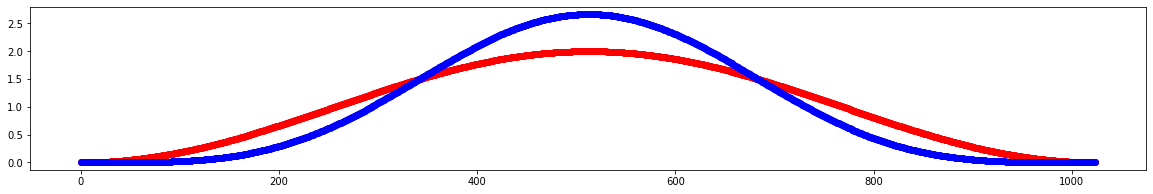

In [5]:
# Generate and plot cosine window (window total is one)

# Set plot size

plt.figure(figsize=(20, 3))

# Set time

t = torch.linspace(0, 1024, 1024, dtype=dtype, device=device)

# Set cosine window of order = 1.0

w = Window(1024, 'cosine_window', 1.0, dtype=dtype, device=device)
print(w)
plt.scatter(t.cpu().numpy(), w.window.cpu().numpy(), color='red', marker='o')

# Reset cosine window with new order

w(name='cosine_window', order=2.0)
print(w)
plt.scatter(t.cpu().numpy(), w.window.cpu().numpy(), c='blue', marker='o')

# Show plots

plt.show()

# Example-04: Kaiser window (normalized max)

Window(1024, 'kaiser_window', 5.0)
Window(1024, 'kaiser_window', 10.0)


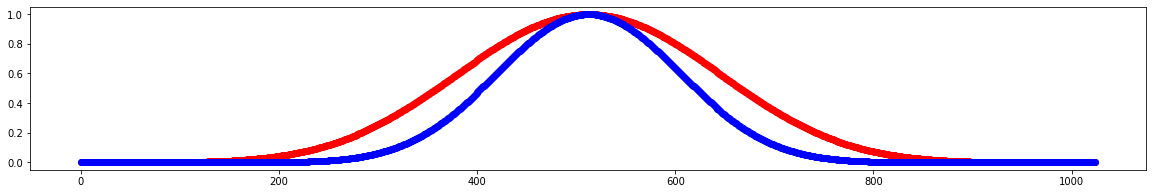

In [6]:
# Generate and plot kaiser window (max value is one)

# Set plot size

plt.figure(figsize=(20, 3))

# Set time

t = torch.linspace(0, 1024, 1024, dtype=dtype, device=device)

# Set kaiser window with order = 5.0

w = Window(1024, 'kaiser_window', 5.0, dtype=dtype, device=device)
print(w)
plt.scatter(t.cpu().numpy(), w.window.cpu().numpy(), color='red', marker='o')

# Reset kaiser window with new order

w(name='kaiser_window', order=10.0)
print(w)
plt.scatter(t.cpu().numpy(), w.window.cpu().numpy(), color='blue', marker='o')

# Show plots

plt.show()

# Example-05: Generate window from staticmethods

In [7]:
# Empty initialization

w = Window(1024, dtype=dtype, device=device)
print(w)
print(w.window.cpu().numpy())

# Generate cosine window data with staticmethod

print(Window.cosine_window(1024, 0.0).cpu().numpy())

# Generate kaiser window data with staticmethod

print(Window.kaiser_window(1024, 0.0).cpu().numpy())

Window(1024, None, None)
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]


# Example-06: Generate window from classmethods

In [8]:
# Initialize using cosine window

w = Window.from_cosine(1024, 0.0, dtype=dtype, device=device)
print(w)
print(w.name)
print(w.order)
print(w.window.detach().cpu().numpy())

# Initialize using kaiser window

w = Window.from_kaiser(1024, 0.0, dtype=dtype, device=device)
print(w)
print(w.name)
print(w.order)
print(w.window.cpu().numpy())

Window(1024, 'cosine_window', 0.0)
cosine_window
0.0
[1. 1. 1. ... 1. 1. 1.]
Window(1024, 'kaiser_window', 0.0)
kaiser_window
0.0
[1. 1. 1. ... 1. 1. 1.]


# Example-07: Weighted mean

In [9]:
# Compare estimation of signal mean without and with window weighting

# Set test signal with 1.E-1 mean value

length = 4096
signal = 1.E-1 + torch.sin(2.0*numpy.pi*0.12345*torch.linspace(0, length, length, dtype=dtype, device=device))

# Compute mean

print(torch.mean(signal))

# Compute weighted mean using cosine window

w = Window.from_cosine(length, 5.0, dtype=dtype, device=device)
print(w)
print(torch.dot(signal, w.window)/w.total)

# Compute weighted mean using kaiser window

w = Window.from_kaiser(length, 10.0, dtype=dtype, device=device)
print(w)
print(torch.dot(signal, w.window)/w.total)

tensor(1.003731971546e-01, dtype=torch.float64)
Window(4096, 'cosine_window', 5.0)
tensor(1.000000000000e-01, dtype=torch.float64)
Window(4096, 'kaiser_window', 10.0)
tensor(1.000000000000e-01, dtype=torch.float64)


# Example-08: Apply window

Window(4096, 'cosine_window', 1.0)


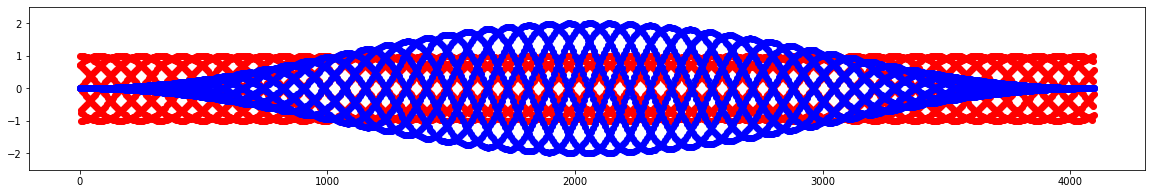

Window(4096, 'kaiser_window', 5.0)


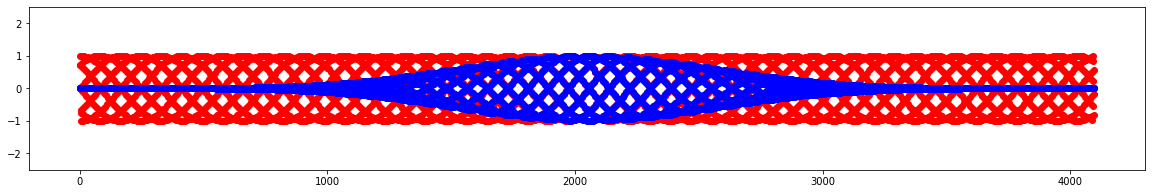

In [10]:
# Apply window to signal and plot result in time domain

# Set test signal

length = 4096
signal = torch.sin(2.0*numpy.pi*0.12345*torch.linspace(0, length, length, dtype=dtype, device=device))


# Set time

t = torch.linspace(0, length, length, dtype=dtype, device=device)

# Set cosine window

w = Window.from_cosine(length, 1.0, dtype=dtype, device=device)
print(w)

# Plot

plt.figure(figsize=(20, 3))
plt.ylim(-2.5, 2.5)
plt.scatter(t.detach().cpu(), signal.detach().cpu(), color='red', marker='o')
plt.scatter(t.detach().cpu(), (signal*w.window).detach().cpu(), color='blue', marker='o')
plt.show()

# Set kaiser window

w = Window.from_kaiser(length, 5.0, dtype=dtype, device=device)
print(w)

# Plot

plt.figure(figsize=(20, 3))
plt.ylim(-2.5, 2.5)
plt.scatter(t.cpu().numpy(), signal.cpu().numpy(), color='red', marker='o')
plt.scatter(t.cpu().numpy(), (signal*w.window).cpu().numpy(), color='blue', marker='o')
plt.show()

# Example-09: Apply window (spectrum)

Window(4096, 'cosine_window', 2.0)


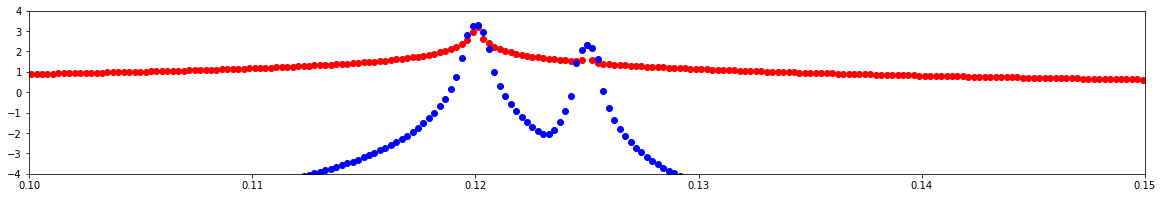

Window(4096, 'cosine_window', 4.0)
tensor(9.998263245766e-01, dtype=torch.float64)
tensor(1.000000000001e+00, dtype=torch.float64)


In [11]:
# Apply window to signal and plot DFT amplitude spectrum

# Set test signal

length = 4096

# Set test signal (two components)

signal = torch.zeros(length, dtype=dtype, device=device)
signal += 1.0*torch.sin(2.0*numpy.pi*0.120*torch.linspace(0, length, length, dtype=dtype, device=device))
signal += 0.1*torch.sin(2.0*numpy.pi*0.125*torch.linspace(0, length, length, dtype=dtype, device=device))

# Set frequency grid

grid = torch.fft.rfftfreq(length, dtype=dtype, device=device)

# Set window

w = Window.from_cosine(length, 2.0, dtype=dtype, device=device)
print(w)

# Plot

plt.figure(figsize=(20, 3))
plt.xlim(0.10, 0.15)
plt.ylim(-4, +4)
plt.scatter(grid.cpu().numpy(), torch.log10(torch.abs(torch.fft.rfft(signal))).cpu().numpy(), color='red', marker='o')
plt.scatter(grid.cpu().numpy(), torch.log10(torch.abs(torch.fft.rfft(signal*w.window))).cpu().numpy(), color='blue', marker='o'),
plt.show()

# Compute parameters with known frequency using convolution without and with window

# Set window 

w = Window.from_cosine(length, 4.0, dtype=dtype, device=device)
print(w)

# Set time

t = torch.linspace(0, length, length, dtype=dtype, device=device)

# Compute s-amplitude without and with window

print(2.0*torch.dot(signal, torch.sin(2.0*numpy.pi*0.120*t))/len(w))
print(2.0*torch.dot(signal*w.window, torch.sin(2.0*numpy.pi*0.120*t))/w.total)